using an example from: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [2]:
import nltk; nltk.download('stopwords')
import re
import numpy as np
import pandas as pd
from pprint import pprint
from tqdm.notebook import tqdm
from collections import Counter
import en_core_web_sm


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maggi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

C:\Users\maggi\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [4]:
# spacy for lemmatization
import spacy
from spacy import displacy

In [5]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# Logging
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


C:\Users\maggi\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [44]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [48]:
len(stop_words)

309

In [47]:
more_stop_words = ['mr','reply','say','go','see','know','get','look','do','take','tell','want','come',\
                  'feel','even','stand','turn','speak','yet','ever','word','back','day','live','rather',\
                  'miss','wish','bring','say','call','do','give','send','set','insist','several','next',\
                  'put','perhaps','thus','much','day','many','declare','other','show','sort','hold',\
                   'always','begin','meet','exclaim','says','said','goes','sees','knows','gets','looks'\
                  'does','takes','tells','wants','seen','seeing','saying', 'came','coming','comes','goes'\
                  'going','gone','hand','hands','handing','look','looks','looked','looking','making','made'\
                  'make','find','finds','good','know','knows','known','knew','knowing','takes','taken','taking'\
                  'think','thinks','thinking','thought','man','men','never','let','lets','does','doing','done'\
                  'did','speak','call','try','trying','tried','almost','woman','women','girl','girls',\
                  'boy','boys','sight','other','explain','explained','explains','want','wants','wanted',\
                  'went','sudden','exclaim','exclaimed','admit','admitted','somewhere','anywhere','everywhere']
stop_words.extend(more_stop_words)

In [10]:
#All Gutenberg metadata
metadata = pd.read_csv('../data/metadata/metadata.csv')

In [11]:
#Select detective/mystery fiction and tales in English
kw = ['fiction','tale']
subj = ['detective', 'mystery','mysteries']
metadata = metadata[metadata['language']=='[\'en\']']
metadata = metadata[metadata['subjects'].apply(lambda x: any([k in x.lower() for k in kw]))]
metadata = metadata[metadata['subjects'].apply(lambda x: any([k in x.lower() for k in subj]))]

#Ids to list
ids = list(metadata['id'])

#List the ids and path for these titles
txts = [[id, '../data/text\\' + id + '_text.txt'] for id in ids]

#note any files that don't exist (duplicates or files that were not utf8) and remove them from the metadata df
docs = []

for idx, filename in tqdm(txts):
    try:
        with open(filename, 'r', encoding = 'utf8') as txt:
            # added encoding = 'utf8' to prevent a continuation byte error
            #txt = f
            #pdf = pdftotext.PDF(f)
            txt = '\n\n'.join(txt)#.lower()
            txt = re.sub('-\s+', '', txt)
            txt = re.sub('--',' ', txt)
            txt = re.sub("\'", "", txt)
            txt = ' '.join(re.findall('[a-zA-z\-]{2,}', txt))
            txt = txt[0:50000]
            docs.append(txt)
    except FileNotFoundError:
        print('WARNING: file not found ', filename)
        metadata = metadata[metadata['id']!=idx]

#Does everything match?
print(len(metadata) == len(docs))
print(len(metadata))

  0%|          | 0/1093 [00:00<?, ?it/s]

True
1052


In [12]:
docs[0:2]

['Proofreaders THE SECRET OF THE TOWER BY ANTHONY HOPE AUTHOR OF THE PRISONER OF ZENDA RUPERT OF HENTZAU ETC CONTENTS DOCTOR MARYS PAYING GUEST II THE GENERAL REMEMBERS III MR SAFFRON AT HOME IV PROFESSIONAL ETIQUETTE FAMILIAR IMPLEMENT VI ODD STORY OF CAPTAIN DUGGLE VII GENTLEMANLY STRANGER VIII CAPTAIN ALEC RAISES HIS VOICE IX DOCTOR MARYS ULTIMATUM THAT MAGICAL WORD MOROCCO XI THE CAR BEHIND THE TREES XII THE SECRET OF THE TOWER XIII RIGHT OF CONQUEST XIV THE SCEPTER IN THE GRAVE XV NORMAL CASE XVI DEAD MAJESTY XVII THE CHIEF MOURNERS XVIII THE GOLD AND THE TREASURE CHAPTER DOCTOR MARYS PAYING GUEST Just in time wasnt it asked Mary Arkroyd Two days before the the ceremony Mercifully it had all been kept very quiet because it was only three months since poor Gilly was killed forget whether you ever met Gilly My half-brother you know Only once in Collingham Gardens He had an _exeat_ and dashed in one Saturday morning when we were just finishing our work Dont you remember Yes think do 

In [13]:
#docs = docs[:5]

In [14]:
#nlp = en_core_web_sm.load()

In [15]:
#for idx, doc in tqdm(enumerate(docs)):
#    this_doc = nlp(doc)
#    ents = [e.text for e in this_doc.ents]
#    for item in ents:
#        doc = doc.replace(' ' + item + ' ', ' ')
#    docs[idx] = doc

In [16]:
#docs[0]

In [17]:
def sent_to_words(sentences):
    for sentence in tqdm(sentences):
        tagged_words = nltk.tag.pos_tag(sentence.split())
        no_names = [word for word, tag in tagged_words if tag != 'NNP' and tag != 'NNPS'] # remove proper nouns
        yield(gensim.utils.simple_preprocess(str(no_names), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(docs))

#print(data_words[:1])

  0%|          | 0/1052 [00:00<?, ?it/s]

In [18]:
#print(data_words[0])

In [19]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
#print(trigram_mod[bigram_mod[data_words[0]]])

In [20]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [65]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
#nlp = spacy.load('en', disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
#data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN'])

#print(data_lemmatized[:1])

In [66]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
#print(corpus[:1])

In [67]:
#id2word[871]
print(str(id2word[11]), str(id2word.cfs[11])) 
id2word.save_as_text('../model_artifacts/id2word_dict03.txt')

agitation 202


In [68]:
# Human readable format of corpus (term-frequency)
#[[(id2word[id], freq) for id, freq in cp] for cp in corpus]
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('accident', 1),
  ('account', 1),
  ('acre', 1),
  ('activity', 1),
  ('address', 2),
  ('admiration', 1),
  ('advice', 1),
  ('affection', 4),
  ('afternoon', 4),
  ('age', 1),
  ('agent', 1),
  ('agitation', 1),
  ('air', 4),
  ('amenity', 1),
  ('amusement', 1),
  ('anger', 1),
  ('angman', 1),
  ('answer', 2),
  ('anticipation', 1),
  ('antidote', 1),
  ('antiquity', 1),
  ('appeal', 1),
  ('appearance', 1),
  ('approval', 1),
  ('argument', 2),
  ('arm', 3),
  ('armchair', 1),
  ('armistice', 2),
  ('arrangement', 2),
  ('arrival', 1),
  ('aspect', 3),
  ('assist', 1),
  ('attainment', 1),
  ('attention', 3),
  ('attraction', 1),
  ('auburn', 1),
  ('audience', 1),
  ('authority', 1),
  ('ave', 1),
  ('avent', 1),
  ('avenue', 2),
  ('bag', 6),
  ('bank', 1),
  ('base', 1),
  ('bean', 2),
  ('bearing', 1),
  ('bed', 2),
  ('beef', 1),
  ('benefit', 1),
  ('billet', 1),
  ('biology', 2),
  ('birth', 1),
  ('birthday', 2),
  ('bit', 2),
  ('blaze', 1),
  ('blighter', 1),
  ('bloo

In [69]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=500,
                                           passes=20,
                                           iterations = 400,
                                           alpha='auto',
                                           per_word_topics=True)
#num_topics = 6
#chunksize = 2000
#passes = 20
#iterations = 400
#eval_every = None  # Don't evaluate model perplexity, takes too much time.

In [70]:
dir(lda_model)
lda_model.save('../model_artifacts/model.lda02_nouns')

In [71]:
model = gensim.models.ldamodel.LdaModel.load('../model_artifacts/model.lda02_nouns')

In [72]:
model.print_topics(num_words = 200)

[(0,
  '0.013*"room" + 0.012*"door" + 0.010*"eye" + 0.010*"time" + 0.010*"case" + 0.008*"moment" + 0.008*"thing" + 0.008*"night" + 0.007*"paper" + 0.007*"face" + 0.006*"friend" + 0.006*"way" + 0.005*"table" + 0.005*"house" + 0.005*"voice" + 0.005*"office" + 0.005*"street" + 0.005*"head" + 0.005*"window" + 0.005*"chair" + 0.004*"hour" + 0.004*"name" + 0.004*"police" + 0.004*"fact" + 0.004*"minute" + 0.004*"sir" + 0.004*"place" + 0.004*"morning" + 0.004*"mind" + 0.004*"course" + 0.004*"question" + 0.004*"body" + 0.004*"life" + 0.003*"world" + 0.003*"foot" + 0.003*"people" + 0.003*"murder" + 0.003*"light" + 0.003*"matter" + 0.003*"side" + 0.003*"evening" + 0.003*"floor" + 0.003*"crime" + 0.003*"gentleman" + 0.003*"business" + 0.003*"year" + 0.003*"story" + 0.003*"corner" + 0.003*"person" + 0.003*"glass" + 0.003*"pocket" + 0.003*"point" + 0.003*"detective" + 0.003*"finger" + 0.003*"note" + 0.003*"arm" + 0.003*"wall" + 0.003*"figure" + 0.003*"part" + 0.003*"money" + 0.002*"word" + 0.002*"de

In [73]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.013*"room" + 0.012*"door" + 0.010*"eye" + 0.010*"time" + 0.010*"case" + '
  '0.008*"moment" + 0.008*"thing" + 0.008*"night" + 0.007*"paper" + '
  '0.007*"face"'),
 (1,
  '0.015*"time" + 0.010*"boat" + 0.010*"way" + 0.009*"water" + 0.008*"thing" + '
  '0.007*"night" + 0.007*"place" + 0.006*"eye" + 0.006*"foot" + 0.005*"side"'),
 (2,
  '0.012*"fan" + 0.004*"bandbox" + 0.003*"mountaineer" + 0.003*"curse" + '
  '0.002*"signalman" + 0.002*"tetradrachm" + 0.001*"plot" + 0.001*"hutchin" + '
  '0.001*"province" + 0.001*"reign"'),
 (3,
  '0.031*"der" + 0.017*"yeou" + 0.015*"warden" + 0.008*"dot" + '
  '0.007*"houseboat" + 0.006*"vas" + 0.004*"church" + 0.004*"crystal_ball" + '
  '0.004*"vos" + 0.004*"haow"'),
 (4,
  '0.009*"eye" + 0.009*"father" + 0.008*"life" + 0.007*"heart" + 0.007*"time" '
  '+ 0.007*"child" + 0.006*"year" + 0.006*"love" + 0.005*"face" + 0.005*"way"'),
 (5,
  '0.020*"car" + 0.018*"father" + 0.012*"time" + 0.010*"room" + 0.010*"door" + '
  '0.009*"way" + 0.009*"scho

In [74]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.8949020525093525

Coherence Score:  0.3297446264643989


In [76]:
# Visualize the topics
pyLDAvis.enable_notebook()
#vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis = gensimvis.prepare(model, corpus, id2word, mds = 'mmds')
#vis = gensimvis.prepare(model, corpus, dictionary, mds = 'mmds', sort_topics=False)
pyLDAvis.save_html(vis, 'lda04.html')
#vis

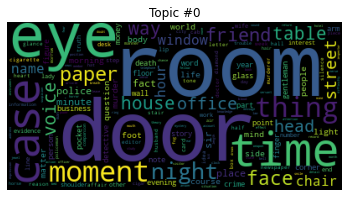

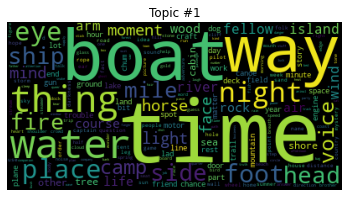

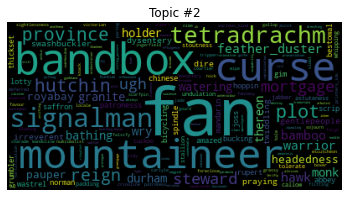

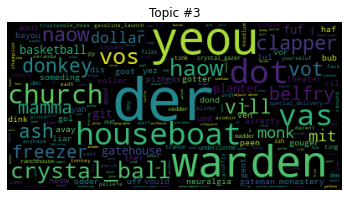

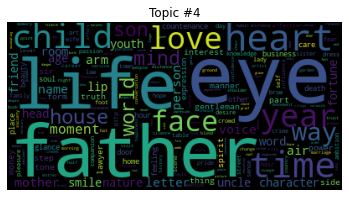

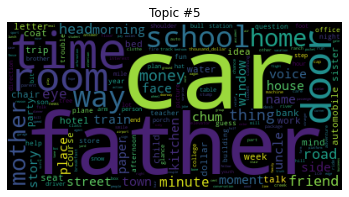

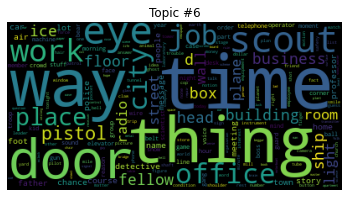

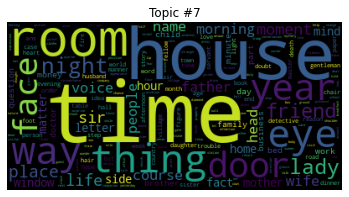

In [75]:
from wordcloud import WordCloud 
for t in range(model.num_topics):
    plt.figure()
    #plt.imshow(WordCloud().fit_words(model.show_topic(t, 200)))
    plt.imshow(WordCloud().fit_words(dict(model.show_topic(t, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

We preprocess the novels by lemmatizing the words, removing
punctuation, function words and names, and splitting the remaining text in chunks of 1000
tokens. We use MALLET to create a topic model with 50 topics. Fig. 1 shows an overview of the
topics with their proportion across the corpus.

Next steps: 

identify and remove named entities before tokenizing

use entire texts instead of first x characters

break into chunks of 1000 tokens for topic modeling -- how does this actually work if you are processing multiple books/texts?

iterate through models with various parameters